Cited from Stable Baseline3 and referred by DDPG
Automated Stock action considering history stock price as continuous data

In [6]:
import gym
import numpy as np
import pandas as pd
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from StockTrade import StockTrade
import os
import gym
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3 import HER, DDPG, DQN, SAC, TD3
from stable_baselines3.her.goal_selection_strategy import GoalSelectionStrategy
from stable_baselines3.common.bit_flipping_env import BitFlippingEnv
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.vec_env.obs_dict_wrapper import ObsDictWrapper

Using Callback function to save Best Training Reward

In [7]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print("Num timesteps: {}".format(self.num_timesteps))
                print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(self.best_mean_reward, mean_reward))

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print("Saving new best model to {}".format(self.save_path))
                  self.model.save(self.save_path)

        return True

Create 'tmp' file to save best Model locally

In [8]:
log_dir = "tmp/"
os.makedirs(log_dir, exist_ok=True)

In [9]:
env_raw = StockTrade(stock_quantity=1, change_stocks=False)
env = Monitor(env_raw, log_dir)

Deep Deterministic Policy Gradient (DDPG) is a model-free off-policy algorithm for learning continous actions.It combines ideas from DPG and DQN. It uses Experience Replay and slow-learning target networks from DQN, and it is based on DPG, which can operate over continuous action spaces.

Using cuda device
Wrapping the env in a DummyVecEnv.
Num timesteps: 2500
Best mean reward: -inf - Last mean reward per episode: -3.62
Saving new best model to tmp/best_model
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 794      |
|    ep_rew_mean     | -3.01    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 63       |
|    time_elapsed    | 50       |
|    total timesteps | 3175     |
| train/             |          |
|    actor_loss      | 1.79e+04 |
|    critic_loss     | 8.4e+05  |
|    learning_rate   | 0.001    |
|    n_updates       | 2176     |
---------------------------------
Num timesteps: 5000
Best mean reward: -3.62 - Last mean reward per episode: -2.63
Saving new best model to tmp/best_model
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 896      |
|    ep_rew_mean     | -2.08    |
| time/              |          |
|    episodes        | 8

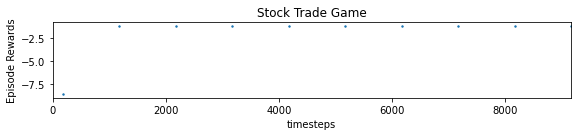

In [10]:
# The noise objects for DDPG
n_actions = env.action_space.shape
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

model = TD3('MlpPolicy', env, action_noise=action_noise, verbose=1)
callback = SaveOnBestTrainingRewardCallback(check_freq=2500, log_dir=log_dir)
timesteps = 10000

model.learn(total_timesteps=int(timesteps), callback=callback)
plot_results([log_dir], timesteps, results_plotter.X_TIMESTEPS, "Stock Trade Game")
plt.show()
model.save("123Automator")

Using cuda device
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 530       |
|    ep_rew_mean     | -3.13     |
| time/              |           |
|    episodes        | 4         |
|    fps             | 88        |
|    time_elapsed    | 23        |
|    total timesteps | 2122      |
| train/             |           |
|    actor_loss      | -2.15e+03 |
|    critic_loss     | 1.32e+06  |
|    learning_rate   | 0.001     |
|    n_updates       | 1027      |
----------------------------------
Num timesteps: 2500
Best mean reward: -inf - Last mean reward per episode: -3.13
Saving new best model to tmp/best_model
Num timesteps: 5000
Best mean reward: -3.13 - Last mean reward per episode: -2.47
Saving new best model to tmp/best_model
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 765       |
|    ep_rew_mean     | -2.14     |
| time/              |           |
|   

Num timesteps: 47500
Best mean reward: -1.32 - Last mean reward per episode: -1.31
Saving new best model to tmp/best_model
Num timesteps: 50000
Best mean reward: -1.31 - Last mean reward per episode: -1.30
Saving new best model to tmp/best_model
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 963       |
|    ep_rew_mean     | -1.3      |
| time/              |           |
|    episodes        | 52        |
|    fps             | 45        |
|    time_elapsed    | 1089      |
|    total timesteps | 50074     |
| train/             |           |
|    actor_loss      | -1.14e+03 |
|    critic_loss     | 1.03e+05  |
|    learning_rate   | 0.001     |
|    n_updates       | 48979     |
----------------------------------
Num timesteps: 52500
Best mean reward: -1.30 - Last mean reward per episode: -1.30
Saving new best model to tmp/best_model
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 966      |
|   

Num timesteps: 95000
Best mean reward: -1.23 - Last mean reward per episode: -1.23
Saving new best model to tmp/best_model
Num timesteps: 97500
Best mean reward: -1.23 - Last mean reward per episode: -1.23
Saving new best model to tmp/best_model
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 980      |
|    ep_rew_mean     | -1.23    |
| time/              |          |
|    episodes        | 100      |
|    fps             | 44       |
|    time_elapsed    | 2182     |
|    total timesteps | 98026    |
| train/             |          |
|    actor_loss      | -25.5    |
|    critic_loss     | 891      |
|    learning_rate   | 0.001    |
|    n_updates       | 96931    |
---------------------------------
Num timesteps: 100000
Best mean reward: -1.23 - Last mean reward per episode: -1.29
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 999      |
|    ep_rew_mean     | -1.15    |
| time/              |  

Num timesteps: 147500
Best mean reward: -1.15 - Last mean reward per episode: -1.15
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 999      |
|    ep_rew_mean     | -1.15    |
| time/              |          |
|    episodes        | 152      |
|    fps             | 45       |
|    time_elapsed    | 3280     |
|    total timesteps | 149974   |
| train/             |          |
|    actor_loss      | -0.471   |
|    critic_loss     | 0.000812 |
|    learning_rate   | 0.001    |
|    n_updates       | 148879   |
---------------------------------
Num timesteps: 150000
Best mean reward: -1.15 - Last mean reward per episode: -1.15
Num timesteps: 152500
Best mean reward: -1.15 - Last mean reward per episode: -1.15
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 999      |
|    ep_rew_mean     | -1.15    |
| time/              |          |
|    episodes        | 156      |
|    fps             | 45       |


Num timesteps: 200000
Best mean reward: -1.15 - Last mean reward per episode: -1.15


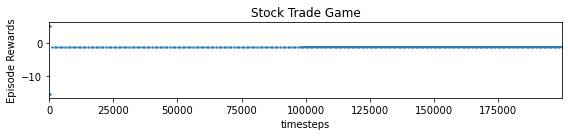

In [5]:
# The noise objects for DDPG
n_actions = env.action_space.shape
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

model = DDPG('MlpPolicy', env, action_noise=action_noise, verbose=1)
callback = SaveOnBestTrainingRewardCallback(check_freq=2500, log_dir=log_dir)
timesteps = 2e5

model.learn(total_timesteps=int(timesteps), callback=callback)
plot_results([log_dir], timesteps, results_plotter.X_TIMESTEPS, "Stock Trade Game")
plt.show()
model.save("123Automator")

Visualization of training model to show its hold, profit,asset and current stock high/low price every day.

In [11]:
obs = env_raw.reset()
dones = False
while not dones:
    
    action, obs = model.predict(obs)
    obs, rewards, dones, _ = env_raw.step(action)
    env.render()
env.close()

#################################
day 2
stock  0
current high: 2.5439
current low: 2.4906
hold: 0.0
asset in hand: 999890.0
#################################
day 3
stock  0
current high: 2.52
current low: 2.461
hold: 0.0
asset in hand: 999780.0
#################################
day 4
stock  0
current high: 2.5557
current low: 2.4668
hold: 0.0
asset in hand: 999670.0
#################################
day 5
stock  0
current high: 2.52
current low: 2.4789
hold: 0.0
asset in hand: 999560.0
#################################
day 6
stock  0
current high: 2.5439
current low: 2.4965
hold: 0.0
asset in hand: 999450.0
#################################
day 7
stock  0
current high: 2.5617
current low: 2.5084
hold: 0.0
asset in hand: 999340.0
#################################
day 8
stock  0
current high: 2.5557
current low: 2.5144
hold: 0.0
asset in hand: 999230.0
#################################
day 9
stock  0
current high: 2.5557
current low: 2.52
hold: 0.0
asset in hand: 999120.0
###############

current low: 2.532
hold: 0.0
asset in hand: 986030.0
#################################
day 129
stock  0
current high: 2.5677
current low: 2.532
hold: 0.0
asset in hand: 985920.0
#################################
day 130
stock  0
current high: 2.5617
current low: 2.5379
hold: 0.0
asset in hand: 985810.0
#################################
day 131
stock  0
current high: 2.5557
current low: 2.5084
hold: 0.0
asset in hand: 985700.0
#################################
day 132
stock  0
current high: 2.5379
current low: 2.5144
hold: 0.0
asset in hand: 985590.0
#################################
day 133
stock  0
current high: 2.5439
current low: 2.5144
hold: 0.0
asset in hand: 985480.0
#################################
day 134
stock  0
current high: 2.5379
current low: 2.5144
hold: 0.0
asset in hand: 985370.0
#################################
day 135
stock  0
current high: 2.55
current low: 2.52
hold: 0.0
asset in hand: 985260.0
#################################
day 136
stock  0
current high: 2.55


current high: 2.6862
current low: 2.6626
hold: 0.0
asset in hand: 978660.0
#################################
day 196
stock  0
current high: 2.7041
current low: 2.6386
hold: 0.0
asset in hand: 978550.0
#################################
day 197
stock  0
current high: 2.6745
current low: 2.6505
hold: 0.0
asset in hand: 978440.0
#################################
day 198
stock  0
current high: 2.6684
current low: 2.6329
hold: 0.0
asset in hand: 978330.0
#################################
day 199
stock  0
current high: 2.6566
current low: 2.6329
hold: 0.0
asset in hand: 978220.0
#################################
day 200
stock  0
current high: 2.6566
current low: 2.6329
hold: 0.0
asset in hand: 978110.0
#################################
day 201
stock  0
current high: 2.6626
current low: 2.6386
hold: 0.0
asset in hand: 978000.0
#################################
day 202
stock  0
current high: 2.6745
current low: 2.6449
hold: 0.0
asset in hand: 977890.0
#################################
day 203
s

current high: 2.3364
current low: 2.2593
hold: 0.0
asset in hand: 966340.0
#################################
day 308
stock  0
current high: 2.2593
current low: 2.1941
hold: 0.0
asset in hand: 966230.0
#################################
day 309
stock  0
current high: 2.2356
current low: 2.1704
hold: 0.0
asset in hand: 966120.0
#################################
day 310
stock  0
current high: 2.1882
current low: 2.1052
hold: 0.0
asset in hand: 966010.0
#################################
day 311
stock  0
current high: 2.2356
current low: 2.1587
hold: 0.0
asset in hand: 965900.0
#################################
day 312
stock  0
current high: 2.2712
current low: 2.1882
hold: 0.0
asset in hand: 965790.0
#################################
day 313
stock  0
current high: 2.2769999999999997
current low: 2.2239
hold: 0.0
asset in hand: 965680.0
#################################
day 314
stock  0
current high: 2.2593
current low: 2.1821
hold: 0.0
asset in hand: 965570.0
###############################

stock  0
current high: 2.0813
current low: 2.0340000000000003
hold: 0.0
asset in hand: 959190.0
#################################
day 373
stock  0
current high: 2.0575
current low: 2.0340000000000003
hold: 0.0
asset in hand: 959080.0
#################################
day 374
stock  0
current high: 2.0575
current low: 2.0279
hold: 0.0
asset in hand: 958970.0
#################################
day 375
stock  0
current high: 2.0575
current low: 1.9983
hold: 0.0
asset in hand: 958860.0
#################################
day 376
stock  0
current high: 2.046
current low: 2.0163
hold: 0.0
asset in hand: 958750.0
#################################
day 377
stock  0
current high: 2.0398
current low: 2.0101
hold: 0.0
asset in hand: 958640.0
#################################
day 378
stock  0
current high: 2.0340000000000003
current low: 1.9983
hold: 0.0
asset in hand: 958530.0
#################################
day 379
stock  0
current high: 2.0398
current low: 1.9983
hold: 0.0
asset in hand: 958420.0

current high: 1.9331
current low: 1.8443
hold: 0.0
asset in hand: 948300.0
#################################
day 472
stock  0
current high: 1.9569999999999999
current low: 1.9036
hold: 0.0
asset in hand: 948190.0
#################################
day 473
stock  0
current high: 2.0043
current low: 1.8858
hold: 0.0
asset in hand: 948080.0
#################################
day 474
stock  0
current high: 1.9569999999999999
current low: 1.9272
hold: 0.0
asset in hand: 947970.0
#################################
day 475
stock  0
current high: 1.945
current low: 1.8619999999999999
hold: 0.0
asset in hand: 947860.0
#################################
day 476
stock  0
current high: 1.9687
current low: 1.9155
hold: 0.0
asset in hand: 947750.0
#################################
day 477
stock  0
current high: 1.939
current low: 1.8916
hold: 0.0
asset in hand: 947640.0
#################################
day 478
stock  0
current high: 1.939
current low: 1.9094
hold: 0.0
asset in hand: 947530.0
##########

#################################
day 560
stock  0
current high: 1.7672
current low: 1.7376
hold: 0.0
asset in hand: 938510.0
#################################
day 561
stock  0
current high: 1.7909
current low: 1.7316
hold: 0.0
asset in hand: 938400.0
#################################
day 562
stock  0
current high: 1.7969
current low: 1.7672
hold: 0.0
asset in hand: 938290.0
#################################
day 563
stock  0
current high: 1.7909
current low: 1.7552
hold: 0.0
asset in hand: 938180.0
#################################
day 564
stock  0
current high: 1.7969
current low: 1.7552
hold: 0.0
asset in hand: 938070.0
#################################
day 565
stock  0
current high: 1.7909
current low: 1.7494
hold: 0.0
asset in hand: 937960.0
#################################
day 566
stock  0
current high: 1.7909
current low: 1.7552
hold: 0.0
asset in hand: 937850.0
#################################
day 567
stock  0
current high: 1.7729
current low: 1.7433
hold: 0.0
asset in hand: 9

current low: 1.3459999999999999
hold: 0.0
asset in hand: 927840.0
#################################
day 658
stock  0
current high: 1.423
current low: 1.3579
hold: 0.0
asset in hand: 927730.0
#################################
day 659
stock  0
current high: 1.4469
current low: 1.3521
hold: 0.0
asset in hand: 927620.0
#################################
day 660
stock  0
current high: 1.4469
current low: 1.3579
hold: 0.0
asset in hand: 927510.0
#################################
day 661
stock  0
current high: 1.429
current low: 1.3521
hold: 0.0
asset in hand: 927400.0
#################################
day 662
stock  0
current high: 1.4469
current low: 1.3936
hold: 0.0
asset in hand: 927290.0
#################################
day 663
stock  0
current high: 1.423
current low: 1.3698
hold: 0.0
asset in hand: 927180.0
#################################
day 664
stock  0
current high: 1.3994
current low: 1.3521
hold: 0.0
asset in hand: 927070.0
#################################
day 665
stock  0
curr

current low: 1.7552
hold: 0.0
asset in hand: 916730.0
#################################
day 759
stock  0
current high: 1.8145
current low: 1.7847
hold: 0.0
asset in hand: 916620.0
#################################
day 760
stock  0
current high: 1.8205
current low: 1.7909
hold: 0.0
asset in hand: 916510.0
#################################
day 761
stock  0
current high: 1.8027
current low: 1.7672
hold: 0.0
asset in hand: 916400.0
#################################
day 762
stock  0
current high: 1.8027
current low: 1.7969
hold: 0.0
asset in hand: 916290.0
#################################
day 763
stock  0
current high: 1.8027
current low: 1.7847
hold: 0.0
asset in hand: 916180.0
#################################
day 764
stock  0
current high: 1.8205
current low: 1.7847
hold: 0.0
asset in hand: 916070.0
#################################
day 765
stock  0
current high: 1.8084
current low: 1.7847
hold: 0.0
asset in hand: 915960.0
#################################
day 766
stock  0
current high:

#################################
day 856
stock  0
current high: 2.2119
current low: 2.1704
hold: 0.0
asset in hand: 905950.0
#################################
day 857
stock  0
current high: 2.2474
current low: 2.1997
hold: 0.0
asset in hand: 905840.0
#################################
day 858
stock  0
current high: 2.2533
current low: 2.2119
hold: 0.0
asset in hand: 905730.0
#################################
day 859
stock  0
current high: 2.2769999999999997
current low: 2.2119
hold: 0.0
asset in hand: 905620.0
#################################
day 860
stock  0
current high: 2.3246
current low: 2.2651
hold: 0.0
asset in hand: 905510.0
#################################
day 861
stock  0
current high: 2.2951
current low: 2.2533
hold: 0.0
asset in hand: 905400.0
#################################
day 862
stock  0
current high: 2.3008
current low: 2.2474
hold: 0.0
asset in hand: 905290.0
#################################
day 863
stock  0
current high: 2.2593
current low: 2.2296
hold: 0.0
asse

#################################
day 956
stock  0
current high: 2.532
current low: 2.4965
hold: 0.0
asset in hand: 894950.0
#################################
day 957
stock  0
current high: 2.5261
current low: 2.4727
hold: 0.0
asset in hand: 894840.0
#################################
day 958
stock  0
current high: 2.55
current low: 2.5024
hold: 0.0
asset in hand: 894730.0
#################################
day 959
stock  0
current high: 2.5557
current low: 2.5261
hold: 0.0
asset in hand: 894620.0
#################################
day 960
stock  0
current high: 2.5557
current low: 2.532
hold: 0.0
asset in hand: 894510.0
#################################
day 961
stock  0
current high: 2.5797
current low: 2.5144
hold: 0.0
asset in hand: 894400.0
#################################
day 962
stock  0
current high: 2.6153
current low: 2.5557
hold: 0.0
asset in hand: 894290.0
#################################
day 963
stock  0
current high: 2.5914
current low: 2.5557
hold: 0.0
asset in hand: 89418

## References
Gin04kg's Deep Reinforcement Learning on Stock Data, from 
https://www.kaggle.com/itoeiji/deep-reinforcement-learning-on-stock-data/notebook
Stable Baseline3, from
https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html

MIT License

Copyright (c) 2020 Shihao Sun, Jianwei Hu

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.